# NN

In [1]:
import cvxpy as cp
import numpy as np
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"
sys.path.insert(1,'E:\\User\\Stevens\\Spring 2024\\PTO - Fairness\\myGit\\myUtils')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, num_items, num_features):
        super(SimpleNeuralNetwork, self).__init__()
        self.num_items = num_items
        self.num_features = num_features
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_features, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            ) for _ in range(num_items)
        ])

    def forward(self, x):
        outputs = []
        for i in range(self.num_items):
            outputs.append(torch.sigmoid(self.layers[i](x[:, i, :])))
        return torch.cat(outputs, dim=1)

In [4]:
def genData(num_data, num_features, num_items, seed=42, Q=100, dim=1, deg=1, noise_width=0.5, epsilon=0.1):
    rnd = np.random.RandomState(seed)
    n = num_data
    p = num_features
    m = num_items
    
    # Split the population into group A (1/4) and group B (3/4)
    group_A_size = n // 4
    group_B_size = n - group_A_size
    
    # Generate x with a bias for group A
    x = np.zeros((n, m, p))
    x[:group_A_size] = rnd.normal(0.5, 1, (group_A_size, m, p))  # Slightly higher mean for group A
    x[group_A_size:] = rnd.normal(0, 1, (group_B_size, m, p))   # Standard distribution for group B
    
    B = rnd.binomial(1, 0.5, (m, p))

    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            values = (np.dot(B[j], x[i, j].reshape(p, 1)).T / np.sqrt(p) + 3) ** deg + 1
            values *= 5
            values /= 3.5 ** deg
            epislon = rnd.uniform(1 - noise_width, 1 + noise_width, 1)
            values *= epislon
            
            # Introduce bias for c: Group A has slightly higher values, Group B slightly lower
            if i < group_A_size:
                values *= 1.1  # Increase c for Group A
            else:
                values *= 0.9  # Decrease c for Group B
            
            values = np.ceil(values)
            c[i, j] = values

    c = c.astype(np.float64)
    r = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            # Generate r using normal distribution, then clip to [0, 1] range
            r[i, j] = np.clip(rnd.normal(0.5, 0.2), 0, 1)
            
            # Introduce bias for r: Group A has slightly lower values, Group B slightly higher
            if i < group_A_size:
                r[i, j] -= 0.1  # Decrease r for Group A
            else:
                r[i, j] += 0.1  # Increase r for Group B
            
            # Clip again to ensure values remain in [0, 1] range
            r[i, j] = np.clip(r[i, j], 0, 1)

    return x, r, c, Q

In [5]:
class optModelClosed:
    """
    This is a class for optimization models.
    """

    def __init__(self, r, c, Q, alpha=0.5):
        self.r = r
        self.c = c
        self.Q = Q
        self.alpha = alpha
        self.num_data = num_data
        self.num_items = num_items
        
    def __repr__(self):
        return 'optModel ' + self.__class__.__name__
    
    def setObj2(self, a, r, b, c, Q, epsilon=0.01, alpha=0.5):
        if alpha == 1:
            self.objective = cp.sum(cp.log(a * r + b * self.d + epsilon))
        else:
            self.objective = cp.sum(cp.power(a * r + b * self.d + epsilon, 1 - alpha)) / (1 - alpha)
        
        self.constraints = [
            cp.sum(cp.multiply(c, self.d)) <= Q
        ]
        
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)
        self.a = a
        self.r = r
        self.b = b
        self.c = c
        self.Q = Q
        self.epsilon = epsilon


    def setObj(self, r, c):

        if self.alpha == 1:
            self.objective = cp.sum(cp.log(cp.multiply(r, self.d)))
        else:
            self.objective = cp.sum(cp.power(cp.multiply(r, self.d), 1 - self.alpha)) / (1 - self.alpha)
        
        self.constraints = [
            self.d >= 0,
            cp.sum(cp.multiply(c, self.d)) <= self.Q
        ]
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)

    
    def solveS(self, closed=False):
        """
        A method to solve the optimization problem for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization
            closed (bool): solving the problem in closed form

        Returns:
            tuple: optimal solution and optimal value
        """
        if closed:
            return self.solveC()

        self.d = cp.Variable(self.num_items)
        self.setObj(self.r, self.c)
        self.problem.solve(abstol=1e-9, reltol=1e-9, feastol=1e-9)
        opt_sol = self.d.value
        opt_val = self.problem.value

        return opt_sol, opt_val


    def solve(self):
        """
        A method to solve the optimization problem in closed form for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization

        Returns:
            tuple: optimal solution and optimal value
        """
        r = self.r
        c = self.c
        if self.alpha == 1:
            raise ValueError("Work in progress")
        c = c.cpu().numpy() if isinstance(c, torch.Tensor) else c
        r = r.cpu().numpy() if isinstance(r, torch.Tensor) else r
        S = np.sum(c ** (1 - 1 / self.alpha) * r ** (-1 + 1 / self.alpha))
        opt_sol_c = (c ** (-1 / self.alpha) * r ** (-1 + 1 / self.alpha) * self.Q) / S
        opt_val_c = np.sum((r * opt_sol_c) ** (1 - self.alpha)) / (1 - self.alpha)

        return opt_sol_c, opt_val_c
    
    def solveC2(self):
        """
        A method to solve the optimization problem in closed form using the given formula.

        Returns:
            tuple: optimal solution and optimal value
        """
        if self.alpha == 1:
            raise ValueError("Work in progress")

        a = self.a
        r = self.r
        b = self.b
        c = self.c
        epsilon = self.epsilon
        Q = self.Q
        alpha = self.alpha

        b_inverse_alpha = b ** (-1 / alpha)
        c_over_b = c / b
        ar_plus_epsilon = a * r + epsilon

        S1 = np.sum(c_over_b * ar_plus_epsilon)
        S2 = np.sum(c_over_b ** (1 - 1 / alpha))

        d_star = b_inverse_alpha * (Q + S1) / S2 - ar_plus_epsilon * b_inverse_alpha / b

        opt_val_c2 = np.sum((a * r + b * d_star + epsilon) ** (1 - alpha)) / (1 - alpha)

        return d_star, opt_val_c2

In [6]:
class optModel:
    """
    This is a class for optimization models.
    """

    def __init__(self, r, c, Q, alpha=0.5):
        self.r = r
        self.c = c
        self.Q = Q
        self.alpha = alpha
        self.num_data = num_data
        self.num_items = num_items

    def __repr__(self):
        return 'optModel ' + self.__class__.__name__
    
    def setObj2(self, a, r, b, c, Q, epsilon=0.01, alpha=0.5):
        if alpha == 1:
            self.objective = cp.sum(cp.log(a * r + b * self.d + epsilon))
        else:
            self.objective = cp.sum(cp.power(a * r + b * self.d + epsilon, 1 - alpha)) / (1 - alpha)
        
        self.constraints = [
            cp.sum(cp.multiply(c, self.d)) <= Q
        ]
        
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)
        self.a = a
        self.r = r
        self.b = b
        self.c = c
        self.Q = Q
        self.epsilon = epsilon


    def get_dual_values(self):
        """
        Returns the dual variables (dual_lambda and mu).
        """
        return self.dual_lambda, self.mu

    def setObj(self, r, c):

        if self.alpha == 1:
            self.objective = cp.sum(cp.log(cp.multiply(r, self.d)))
        else:
            self.objective = cp.sum(cp.power(cp.multiply(r, self.d), 1 - self.alpha)) / (1 - self.alpha)
        
        self.constraints = [
            self.d >= 0,
            cp.sum(cp.multiply(c, self.d)) <= self.Q
        ]
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)

    
    def solve(self, closed=False):
        """
        A method to solve the optimization problem for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization
            closed (bool): solving the problem in closed form

        Returns:
            tuple: optimal solution and optimal value
        """
        if closed:
            return self.solveC()

        self.d = cp.Variable(self.num_items)
        self.setObj(self.r, self.c)
        self.problem.solve(abstol=1e-9, reltol=1e-9, feastol=1e-9)
        opt_sol = self.d.value
        opt_val = self.problem.value

        return opt_sol, opt_val


    def solveC(self):
        """
        A method to solve the optimization problem in closed form for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization

        Returns:
            tuple: optimal solution and optimal value
        """
        r = self.r
        c = self.c
        if self.alpha == 1:
            raise ValueError("Work in progress")
        c = c.cpu().numpy() if isinstance(c, torch.Tensor) else c
        r = r.cpu().numpy() if isinstance(r, torch.Tensor) else r
        S = np.sum(c ** (1 - 1 / self.alpha) * r ** (-1 + 1 / self.alpha))
        opt_sol_c = (c ** (-1 / self.alpha) * r ** (-1 + 1 / self.alpha) * self.Q) / S
        opt_val_c = np.sum((r * opt_sol_c) ** (1 - self.alpha)) / (1 - self.alpha)

        return opt_sol_c, opt_val_c
    
    def solveC2(self):
        """
        A method to solve the optimization problem in closed form using the given formula.

        Returns:
            tuple: optimal solution and optimal value
        """
        if self.alpha == 1:
            raise ValueError("Work in progress")

        a = self.a
        r = self.r
        b = self.b
        c = self.c
        epsilon = self.epsilon
        Q = self.Q
        alpha = self.alpha

        b_inverse_alpha = b ** (-1 / alpha)
        c_over_b = c / b
        ar_plus_epsilon = a * r + epsilon

        S1 = np.sum(c_over_b * ar_plus_epsilon)
        S2 = np.sum(c_over_b ** (1 - 1 / alpha))

        d_star = b_inverse_alpha * (Q + S1) / S2 - ar_plus_epsilon * b_inverse_alpha / b

        opt_val_c2 = np.sum((a * r + b * d_star + epsilon) ** (1 - alpha)) / (1 - alpha)

        return d_star, opt_val_c2

In [7]:
class optDataset(Dataset):
    """
    This class is Torch Dataset class for optimization problems.
    """

    def __init__(self, features, costs, r, Q, alpha=0.5, closed=False):
        """
        A method to create a optDataset from optModel

        Args:
            model (optModel): optimization model
            features (np.ndarray): features
            c (np.ndarray): c of objective function
            r (np.ndarray): r of objective function
            Q (float): budget
            alpha (float): alpha of objective function
            closed (bool): solving the problem in closed form

        """
        self.feats = features
        self.costs = costs
        self.r = r
        self.Q = Q
        self.alpha = alpha
        self.closed = closed

        self.sols, self.objs = self._getSols()

    def _getSols(self):
        """
        A method to get the solutions of the optimization problem
        """
        opt_sols = []
        opt_objs = []
        
        for i in tqdm(range(len(self.costs))):
            sol, obj = self._solve(self.r[i], self.costs[i])
            opt_sols.append(sol)
            opt_objs.append([obj])
        
        return np.array(opt_sols), np.array(opt_objs)

    def  _solve(self, r, c):
        """
        A method to solve the optimization problem to get oan optimal solution with given r and c

        Args:
            r (np.ndarray): r of objective function
            c (np.ndarray): c of objective function

        Returns:
            tuple: optimal solution (np.ndarray), objective value (float)
        """
        self.model = optModelClosed(r, c, self.Q, self.alpha)
        if self.closed:
            return self.model.solveC()
        else:
            return self.model.solve()

    def __len__(self):
        """
        A method to get data size

        Returns:
            int: the number of optimization problems
        """
        return len(self.costs)
    
    def __getitem__(self, index):
        """
        A method to retrieve data

        Args:
            index (int): data index

        Returns:
            tuple: data features (torch.tensor), costs (torch.tensor), optimal solutions (torch.tensor) and objective values (torch.tensor)
        """
        return (
            torch.FloatTensor(self.feats[index]), # x 
            torch.FloatTensor(self.costs[index]), # c
            torch.FloatTensor(self.r[index]), # r 
            torch.FloatTensor(self.sols[index]),# optimal solution
            torch.FloatTensor(self.objs[index]), # objective value
        )

In [8]:
class LinearRegressionModel(nn.Module):
    def __init__(self, num_items, num_features):
        super(LinearRegressionModel, self).__init__()
        self.num_items = num_items
        self.num_features = num_features
        self.linears = nn.ModuleList([nn.Linear(num_features, 1) for _ in range(num_items)])

    def forward(self, x):
        outputs = []
        for i in range(self.num_items):
            outputs.append(torch.sigmoid(self.linears[i](x[:, i, :])))
        return torch.cat(outputs, dim=1)

In [9]:
def objValue(d, r, alpha=0.5):
    """
    A function to calculate objective value
    """
    if alpha == 1:
        return np.sum(np.log(np.multiply(r, d)))
    else:
        return np.sum(np.power(np.multiply(r, d), 1 - alpha)) / (1 - alpha)

def regret(predmodel, optmodel, dataloader):
    """
    A function to evaluate model performance with normalized true regret

    Args:
        predmodel (nn): a regression neural network for cost prediction
        optmodel (optModel): an PyEPO optimization model
        dataloader (DataLoader): Torch dataloader from optDataSet

    Returns:
        float: true regret loss
    """
    # evaluate
    predmodel.eval()
    loss = 0
    optsum = 0
    # load data
    for data in dataloader:
        x, c, r, d, z  = data
        # cuda
        if next(predmodel.parameters()).is_cuda:
            x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()
        # predict
        with torch.no_grad(): # no grad
            rp = predmodel(x).to("cpu").detach().numpy()
        # solve
        for j in range(rp.shape[0]):
            # accumulate loss
            loss += calRegret(optModel, c[j].to("cpu").detach().numpy(), rp[j], r[j].to("cpu").detach().numpy(),
                              z[j].item())
        optsum += abs(z).sum().item()
    # turn back train mode
    predmodel.train()
    # normalized
    return loss / (optsum + 1e-7)


def calRegret(optmodel, cost, pred_r, true_r, true_obj):
    """
    A function to calculate normalized true regret for a batch

    Args:
        optmodel (optModel): optimization model
        pred_cost (torch.tensor): predicted costs
        true_cost (torch.tensor): true costs
        true_obj (torch.tensor): true optimal objective values

    Returns:predmodel
        float: true regret losses
    """
    # opt sol for pred cost
    model = optmodel(pred_r, cost, Q, alpha=0.5)
    sol, _ = model.solve()
    # obj with true cost
    obj = objValue(sol, true_r, alpha=0.5)
    # loss
    loss = true_obj - obj
    return loss

In [10]:
def visLearningCurve(loss_log, loss_log_regret, mse_loss_log):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

    # Plot original loss log
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve (Training Loss)", fontsize=16)

    # Plot regret log
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve (Test Regret)", fontsize=16)

    # Plot new MSE loss log
    ax3.plot(mse_loss_log, color="orange", lw=2)
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Iters", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title("Learning Curve (MSE Loss)", fontsize=16)

    plt.tight_layout()
    plt.show()

### Generate Data

In [11]:
num_data = 2000
num_features = 20
num_items = 5
x, r, c, Q = genData(num_data, num_features, num_items)
# create optmodel instance
optmodel = optModel(r, c, Q, alpha=0.5)

In [12]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test, r_train, r_test = train_test_split(x, c, r, test_size=0.2, random_state=42)

In [13]:
# Create datasets and dataloaders
dataset_train = optDataset(x_train, c_train, r_train, Q, alpha=0.5, closed=False)
dataset_test = optDataset(x_test, c_test, r_test, Q, alpha=0.5, closed=False)
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

100%|██████████| 1600/1600 [00:00<00:00, 89006.16it/s]


100%|██████████| 400/400 [00:00<00:00, 72843.07it/s]


In [14]:
# view one slice of data
r[0]

array([0.42782192, 0.39185518, 0.25602175, 0.85686333, 0.22423475])

## The Pertubed Gradient Regret Loss

In [15]:
# Define Pertubed Regret Loss
from torch.autograd import Function

class RegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        for i in range(batch_size):
            # opt sol for pred cost
            model = optmodel(pred_r_np[i], cost_np[i], Q, alpha=alpha)
            sol, _ = model.solve()
            # obj with true cost
            obj = objValue(sol, true_r_np[i], alpha=alpha)

            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(pred_r, true_r, cost, true_obj)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.losses = losses

        return losses.mean().to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):

        pred_r, true_r, cost, true_obj = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)
        
        epsilon = 1e-5

        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()
            
            gradient = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r = np.copy(pred_r_np)
                perturbed_pred_r[j] += epsilon
                
                # Compute loss with perturbed pred_r
                model = optmodel(perturbed_pred_r, cost_np, Q, alpha=alpha)
                sol, _ = model.solve()
                obj = objValue(sol, true_r_np, alpha=alpha)
                loss_perturbed = true_obj[i] - obj
                
                # Finite difference approximation
                gradient[j] = (loss_perturbed - ctx.losses[i].item()) / epsilon
            
            grad_pred_r[i] = torch.tensor(gradient, device=pred_r.device)
        
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        return None, None, grad_pred_r, None, None, None, None

class RegretLoss(nn.Module):
    def __init__(self, optmodel, Q, alpha=0.5):
        super(RegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, pred_r, true_r, cost, true_obj):
        return RegretLossFunction.apply(self.optmodel, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


In [16]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()  # Fixed MSE loss metric
    predmodel.train()
    
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    mse_loss_log = []  # New MSE loss log
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)  # Forward pass

            # Compute the regret loss (original loss)
            loss = loss_func(rp, r, c, z)
            # Compute MSE loss (new fixed metric)
            mse_loss = mse_loss_func(rp, r)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())
            mse_loss_log.append(mse_loss.item())  # Log the MSE loss

        # Compute and log the regret loss after each epoch
        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print(f"Epoch {epoch + 1:2},  Loss: {loss.item():9.4f},  MSE: {mse_loss.item():7.4f},  Regret: {regret_loss * 100:7.4f}%")

    print(f"Total Elapsed Time: {elapsed:.2f} Sec.")
    return loss_log, loss_log_regret, mse_loss_log  # Return MSE loss log as well

## E2E using solver on regret loss with pertubed gradient

Epoch  1,  Loss:    0.1536,  MSE:  0.0436,  Regret:  1.7043%
Epoch  2,  Loss:    0.2316,  MSE:  0.0515,  Regret:  1.6989%
Epoch  3,  Loss:    0.1861,  MSE:  0.0398,  Regret:  1.6940%
Epoch  4,  Loss:    0.2168,  MSE:  0.0462,  Regret:  1.6945%
Epoch  5,  Loss:    0.2087,  MSE:  0.0402,  Regret:  1.7040%
Epoch  6,  Loss:    0.3132,  MSE:  0.0535,  Regret:  1.7044%
Epoch  7,  Loss:    0.1836,  MSE:  0.0429,  Regret:  1.7181%
Epoch  8,  Loss:    0.2409,  MSE:  0.0421,  Regret:  1.7171%
Epoch  9,  Loss:    0.3600,  MSE:  0.0509,  Regret:  1.7279%
Epoch 10,  Loss:    0.2292,  MSE:  0.0423,  Regret:  1.7236%
Total Elapsed Time: 9923.34 Sec.


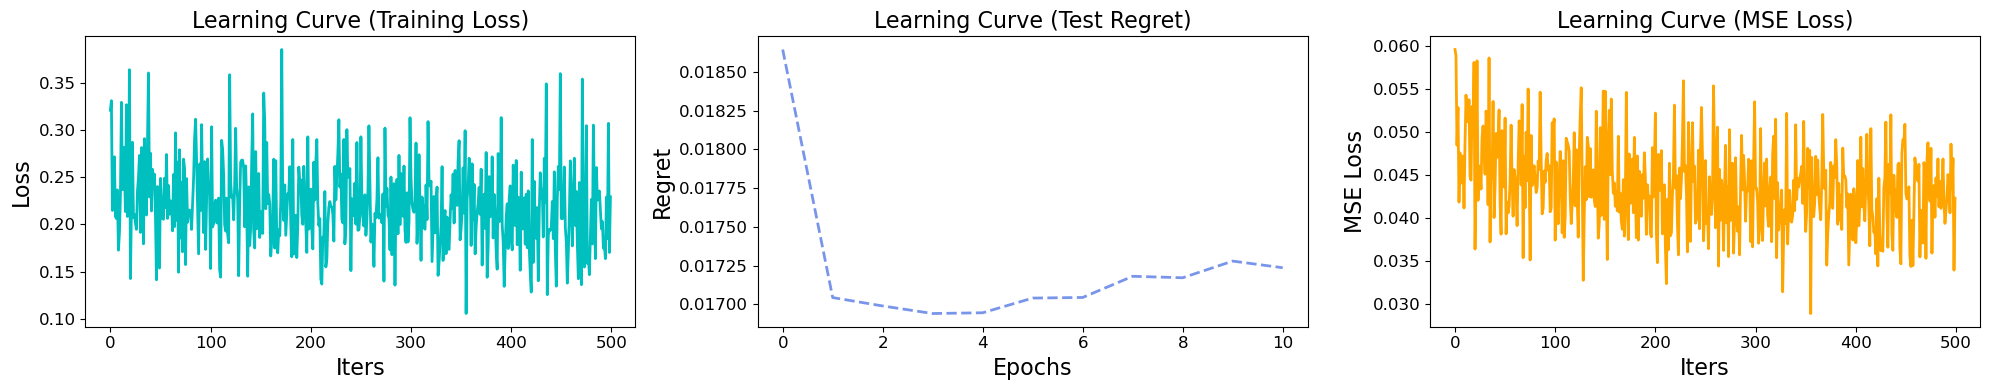

In [22]:
optmodel = optModel
model = SimpleNeuralNetwork(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLoss(optModel,Q)

# Run the training
loss_log, loss_log_regret, mse_loss_log = trainModel(model, criterion, num_epochs=10, lr=1e-3)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret, mse_loss_log)

In [19]:
# optmodel = optModel
# model = SimpleNeuralNetwork(num_items, num_features).to(device)
# # criterion = nn.MSELoss()
# criterion = RegretLoss(optModel,Q)

# # Run the training
# loss_log, loss_log_regret, mse_loss_log = trainModel(model, criterion, num_epochs=10, lr=1e-3)

# # Visualize the learning curves
# visLearningCurve(loss_log, loss_log_regret, mse_loss_log)

## E2E using closed-form solution on regret loss with pertubed gradient

In [23]:
optmodel = optModelClosed
model = SimpleNeuralNetwork(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLoss(optModelClosed,Q)

# Run the training
loss_log, loss_log_regret, mse_loss_log = trainModel(model, criterion, num_epochs=10, lr=1e-3)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret, mse_loss_log)

Epoch  1,  Loss:    0.2041,  MSE:  0.0423,  Regret:  1.7194%
Epoch  2,  Loss:    0.2807,  MSE:  0.0517,  Regret:  1.7156%
Epoch  3,  Loss:    0.1772,  MSE:  0.0409,  Regret:  1.7168%
Epoch  4,  Loss:    0.1658,  MSE:  0.0364,  Regret:  1.7164%


## 2-Stage with MSELoss

- Epoch  1,  Loss:    0.0448,  Regret:  1.7459% 
- Epoch  2,  Loss:    0.0394,  Regret:  1.7291%
- Epoch  3,  Loss:    0.0474,  Regret:  1.7376%
- Epoch  4,  Loss:    0.0424,  Regret:  1.7295%
- Epoch  5,  Loss:    0.0405,  Regret:  1.7173%
- Epoch  6,  Loss:    0.0403,  Regret:  1.7311%
- Epoch  7,  Loss:    0.0439,  Regret:  1.7218%
- Epoch  8,  Loss:    0.0412,  Regret:  1.7435%
- Epoch  9,  Loss:    0.0428,  Regret:  1.7452%
- Epoch 10,  Loss:    0.0419,  Regret:  1.7397%
- Total Elapsed Time: 43.66 Sec.

In [79]:
# simply MSE training 
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    predmodel.train()
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)
            
            # loss = loss_func(rp, r) if using torch.nn.MSELoss
            loss = loss_func(rp, r)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())

        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch + 1, loss.item(), regret_loss * 100))
    predmodel.eval()
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

# Define the visualization function
def visLearningCurve(loss_log, loss_log_regret):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.03)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

In [86]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()  # Fixed MSE loss metric
    predmodel.train()
    
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    mse_loss_log = []  # New MSE loss log
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)  # Forward pass

            # Compute the regret loss (original loss)
            loss = loss_func(rp, r, c, z)
            # Compute MSE loss (new fixed metric)
            mse_loss = mse_loss_func(rp, r)

            mse_loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())
            mse_loss_log.append(mse_loss.item())  # Log the MSE loss

        # Compute and log the regret loss after each epoch
        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print(f"Epoch {epoch + 1:2},  Loss: {loss.item():9.4f},  MSE: {mse_loss.item():7.4f},  Regret: {regret_loss * 100:7.4f}%")

    print(f"Total Elapsed Time: {elapsed:.2f} Sec.")
    return loss_log, loss_log_regret, mse_loss_log  # Return MSE loss log as well

In [87]:
def visLearningCurve(loss_log, loss_log_regret, mse_loss_log):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

    # Plot original loss log
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve (Training Loss)", fontsize=16)

    # Plot regret log
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve (Test Regret)", fontsize=16)

    # Plot new MSE loss log
    ax3.plot(mse_loss_log, color="orange", lw=2)
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Iters", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title("Learning Curve (MSE Loss)", fontsize=16)

    plt.tight_layout()
    plt.show()

Epoch  1,  Loss:    0.3300,  MSE:  0.0424,  Regret:  1.7257%
Epoch  2,  Loss:    0.2415,  MSE:  0.0419,  Regret:  1.7529%
Epoch  3,  Loss:    0.1870,  MSE:  0.0376,  Regret:  1.7450%
Epoch  4,  Loss:    0.2651,  MSE:  0.0468,  Regret:  1.7407%
Epoch  5,  Loss:    0.2469,  MSE:  0.0415,  Regret:  1.7259%
Epoch  6,  Loss:    0.2785,  MSE:  0.0432,  Regret:  1.7534%
Epoch  7,  Loss:    0.3274,  MSE:  0.0468,  Regret:  1.7502%
Epoch  8,  Loss:    0.2090,  MSE:  0.0416,  Regret:  1.7610%
Epoch  9,  Loss:    0.2699,  MSE:  0.0452,  Regret:  1.7678%
Epoch 10,  Loss:    0.2202,  MSE:  0.0391,  Regret:  1.7241%
Total Elapsed Time: 1370.48 Sec.


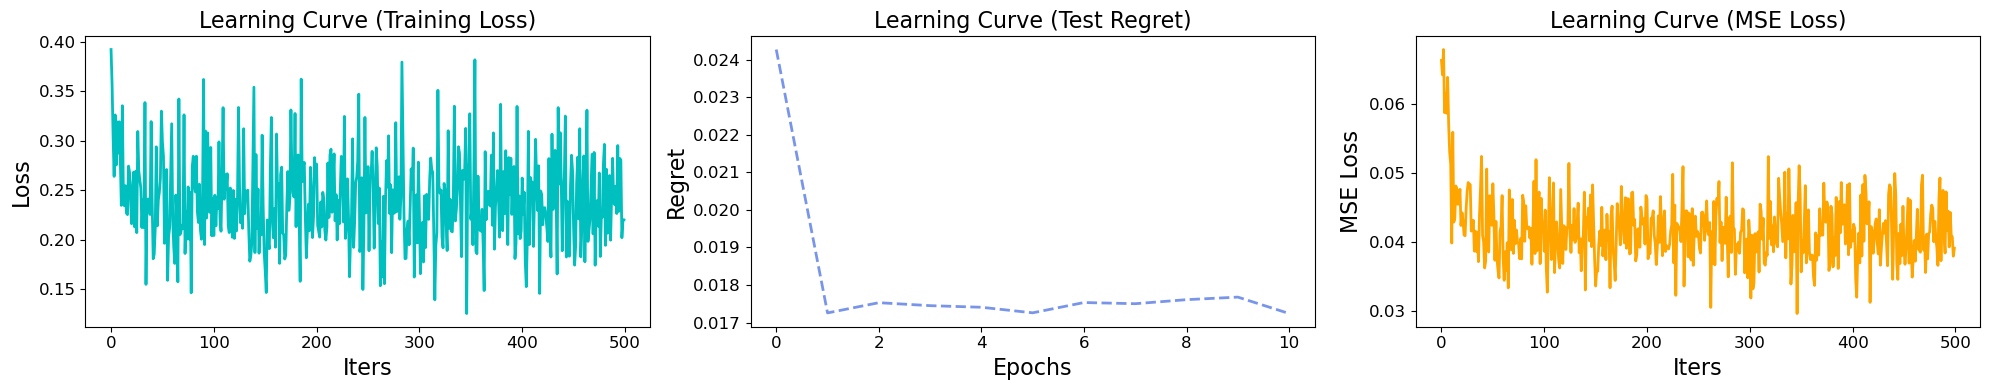

In [89]:

# Set up the model, optimizer, and MSE loss
optmodel = optModel
model = SimpleNeuralNetwork(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLoss(optModel,Q)

# Run the training
loss_log, loss_log_regret, mse_loss_log = trainModel(model, criterion, num_epochs=10, lr=1e-3)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret, mse_loss_log)

## E2E using closed-form solutions w analytical gradient

In [19]:
def closed_form_solution_and_gradient(c, r, Q=Q, alpha=0.5):
    """
    Compute the closed-form solution d* and its gradient with respect to r.

    Args:
        c (np.ndarray): cost vector
        r (np.ndarray): prediction vector
        Q (float): budget
        alpha (float): parameter alpha

    Returns:
        tuple: optimal solution (d*), gradient of d* with respect to r
    """
    S = np.sum(c ** (1 - 1 / alpha) * r ** (-1 + 1 / alpha))
    d_star = (c ** (-1 / alpha) * r ** (-1 + 1 / alpha) * Q) / S
    
    # Gradient of d* with respect to r
    grad_d_star_r = np.zeros_like(r)
    for i in range(len(r)):
        A_i = c[i] ** (-1 / alpha) * r[i] ** (-1 + 1 / alpha)
        grad_d_star_r[i] = Q * ((-1 + 1 / alpha) * c[i] ** (-1 / alpha) * r[i] ** (-2 + 1 / alpha) * (S - c[i] ** (1 - 1 / alpha) * r[i] ** (-1 + 1 / alpha))) / S**2
    
    return grad_d_star_r

In [20]:
class RegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        # Keep tensors within PyTorch
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        solutions = []  # Save solutions for use in backward pass
        
        for i in range(batch_size):
            # Solve the optimization problem using pred_r
            model = optmodel(pred_r_np[i], cost_np[i], Q, alpha=alpha)
            sol, _ = model.solve()
            solutions.append(sol)
            
            # Calculate the objective with the true reward
            obj = objValue(sol, true_r_np[i], alpha=alpha)

            # Calculate the regret (loss)
            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(pred_r, true_r, cost, true_obj)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.solutions = solutions  # Save the solutions
        ctx.losses = losses

        return losses.mean()

    @staticmethod
    def backward(ctx, grad_output):
        pred_r, true_r, cost, true_obj = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha
        solutions = ctx.solutions

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)

        epsilon = 1e-5  # Perturbation step size for finite differences
        
        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()

            # Analytical gradient of d(rp) w.r.t rp using the provided closed-form formula
            grad_d_star_r = closed_form_solution_and_gradient(cost_np, pred_r_np, Q=Q, alpha=alpha)
            
            # Compute loss with respect to d(rp) by finite differences
            perturbed_grad_loss_d_rp = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r = np.copy(pred_r_np)
                
                # Solve the optimization problem with perturbed predicted rewards
                model = optmodel(perturbed_pred_r, cost_np, Q, alpha=alpha)
                sol, _ = model.solve()
                
                # Calculate the objective with true rewards
                obj_perturbed = objValue(sol, true_r_np, alpha=alpha) + epsilon
                loss_perturbed = true_obj[i] - obj_perturbed
                
                # Calculate the gradient of the loss with respect to d(rp)
                perturbed_grad_loss_d_rp[j] = (loss_perturbed - ctx.losses[i].item()) / epsilon
            
            # Multiply the gradients: loss/d(rp) * d(rp)/rp
            grad_pred_r[i] = torch.tensor(perturbed_grad_loss_d_rp, device=pred_r.device) * torch.tensor(grad_d_star_r, device=pred_r.device)

        # Scale the gradient by grad_output
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        return None, None, grad_pred_r, None, None, None, None


In [21]:
class RegretLoss(nn.Module):
    def __init__(self, optmodel, Q, alpha=0.5):
        super(RegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, pred_r, true_r, cost, true_obj):
        return RegretLossFunction.apply(self.optmodel, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


In [22]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()  # Fixed MSE loss metric
    predmodel.train()
    
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    mse_loss_log = []  # New MSE loss log
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)  # Forward pass

            # Compute the regret loss (original loss)
            loss = loss_func(rp, r, c, z)
            # Compute MSE loss (new fixed metric)
            mse_loss = mse_loss_func(rp, r)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())
            mse_loss_log.append(mse_loss.item())  # Log the MSE loss

        # Compute and log the regret loss after each epoch
        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print(f"Epoch {epoch + 1:2},  Loss: {loss.item():9.4f},  MSE: {mse_loss.item():7.4f},  Regret: {regret_loss * 100:7.4f}%")

    print(f"Total Elapsed Time: {elapsed:.2f} Sec.")
    return loss_log, loss_log_regret, mse_loss_log  # Return MSE loss log as well

Epoch  1,  Loss:    0.3497,  MSE:  0.0748,  Regret:  2.1157%
Epoch  2,  Loss:    0.2760,  MSE:  0.1035,  Regret:  1.9592%
Epoch  3,  Loss:    0.3619,  MSE:  0.1464,  Regret:  1.7979%
Epoch  4,  Loss:    0.2321,  MSE:  0.1329,  Regret:  1.7228%
Epoch  5,  Loss:    0.2069,  MSE:  0.1407,  Regret:  1.6856%
Epoch  6,  Loss:    0.3045,  MSE:  0.2068,  Regret:  1.6719%
Epoch  7,  Loss:    0.2975,  MSE:  0.1991,  Regret:  1.6660%
Epoch  8,  Loss:    0.2895,  MSE:  0.2126,  Regret:  1.6630%
Epoch  9,  Loss:    0.2510,  MSE:  0.1681,  Regret:  1.6623%
Epoch 10,  Loss:    0.2333,  MSE:  0.1973,  Regret:  1.6609%
Epoch 11,  Loss:    0.2092,  MSE:  0.1852,  Regret:  1.6605%
Epoch 12,  Loss:    0.2122,  MSE:  0.2242,  Regret:  1.6598%
Epoch 13,  Loss:    0.2359,  MSE:  0.2105,  Regret:  1.6601%
Epoch 14,  Loss:    0.1754,  MSE:  0.2055,  Regret:  1.6601%
Epoch 15,  Loss:    0.2710,  MSE:  0.2268,  Regret:  1.6602%
Epoch 16,  Loss:    0.2651,  MSE:  0.2178,  Regret:  1.6601%
Epoch 17,  Loss:    0.26

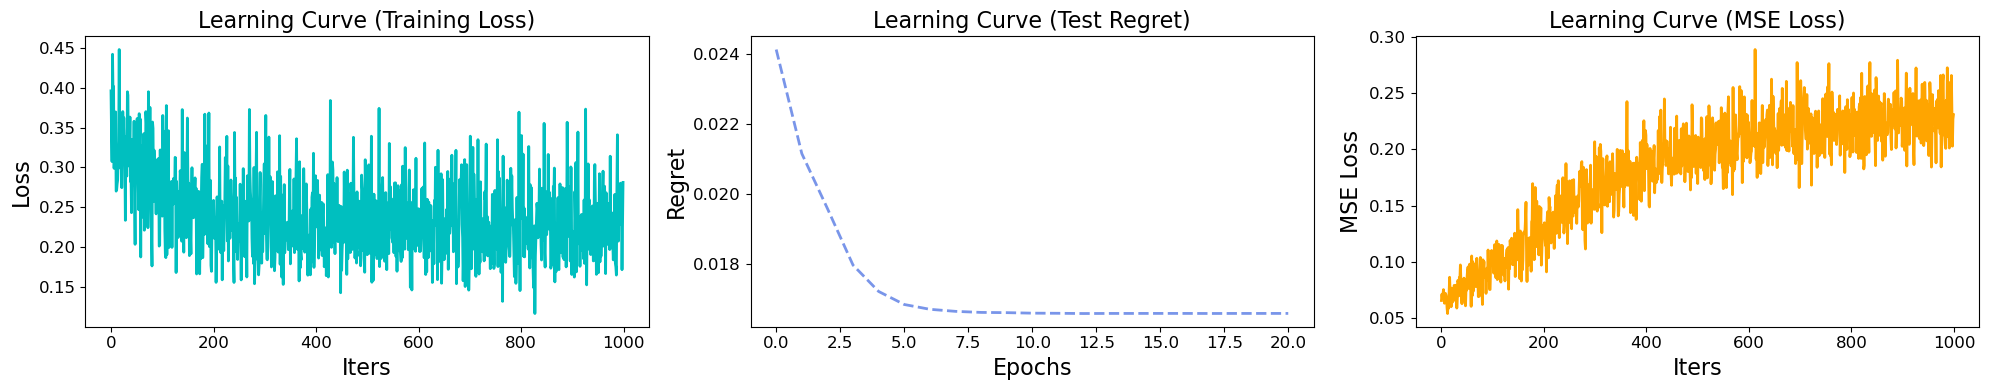

In [23]:
# Set up the model, optimizer, and MSE loss
optmodel = optModelClosed
model = SimpleNeuralNetwork(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLoss(optmodel,Q)

# Run the training
loss_log, loss_log_regret, mse_loss_log = trainModel(model, criterion, num_epochs=10, lr=1e-3)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret, mse_loss_log)

## E2E using solver on regret loss with KKT Matrix

In [67]:
from scipy.linalg import solve, pinv


# Helper function to check matrix invertibility
def is_invertible(matrix):
    return np.linalg.cond(matrix) < 1 / np.finfo(matrix.dtype).eps

def solve_rd_matrix_system(r, c, d_i, mu, lambda_i, Q=100, alpha=0.5):
    n = len(r)
    
    # Step 1: Construct Hessian of the objective function (H_dd)
    A_elements = [alpha * r[i]**2 * (r[i] * d_i[i])**(-alpha - 1) for i in range(n)]
    H_dd = np.diag(A_elements)
    
    # Step 2: Construct Jacobians of inequality constraints (g(d;r)) and equality constraints (h(d;r))
    B = -np.eye(n)  # Jacobian of g(d;r) = d >= 0 is -I
    C = c.reshape(-1, 1)  # Jacobian of h(d;r) = sum(c * d) - Q is the vector of c_i's
    
    # Step 3: Construct D and M matrices
    D = np.diag(d_i)  # Diagonal matrix with d_i's
    M = mu * c.reshape(1, -1)  # Row vector of mu * c
    
    # Step 4: Complementary slackness matrix with lambda_i
    if lambda_i.ndim > 2:
        raise ValueError(f"lambda_i has too many dimensions: {lambda_i.ndim}")
    lambda_i = lambda_i.flatten()  # Ensure it's 1-dimensional
    Lambda = np.diag(lambda_i)  # Diagonal matrix from lambda_i
    
    # Step 5: Construct the full block matrix system
    LHS = np.block([
        [H_dd, B, C],  # First row block
        [Lambda, D, np.zeros((n, 1))],  # Second row block
        [M, np.zeros((1, n)), np.array([[np.sum(c * d_i) - Q]])]  # Third row block
    ])
    
    # Step 6: Construct the RHS vector
    v = np.array([-alpha * r[i] * (r[i] * d_i[i])**(-alpha - 1) for i in range(n)])
    RHS = np.hstack([v, np.zeros(n), np.zeros(1)])
    
    # Step 7: Solve the matrix system
    if is_invertible(LHS):
        solution = solve(LHS, RHS)
        d_r_derivatives = solution[:n]
        return d_r_derivatives
    else:
        solution = np.dot(pinv(LHS), RHS)
        return solution[:n]

In [49]:
class optModelMatrix:
    """
    This is a class for optimization models.
    """

    def __init__(self, r, c, Q, alpha=0.5):
        self.r = r
        self.c = c
        self.Q = Q
        self.alpha = alpha
        self.num_data = num_data
        self.num_items = num_items

        
    def __repr__(self):
        return 'optModel ' + self.__class__.__name__

    def setObj(self, r, c):

        if self.alpha == 1:
            self.objective = cp.sum(cp.log(cp.multiply(r, self.d)))
        else:
            self.objective = cp.sum(cp.power(cp.multiply(r, self.d), 1 - self.alpha)) / (1 - self.alpha)
        
        self.constraints = [
            self.d >= 0,
            cp.sum(cp.multiply(c, self.d)) <= self.Q
        ]
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)


    def solve(self, closed=False):
        """
        A method to solve the optimization problem for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization
            closed (bool): solving the problem in closed form

        Returns:
            tuple: optimal solution and optimal value
        """
        if closed:
            return self.solveC()

        self.d = cp.Variable(self.num_items)
        self.setObj(self.r, self.c)
        self.problem.solve(abstol=1e-9, reltol=1e-9, feastol=1e-9)
        opt_sol = self.d.value
        opt_val = self.problem.value


        # Dual values for the constraints
        lambdas = self.constraints[0].dual_value
        mus = self.constraints[1].dual_value
    
        return opt_sol, opt_val, lambdas, mus
    
class optDatasetMatrix(Dataset):
    """
    This class is Torch Dataset class for optimization problems.
    """

    def __init__(self, features, costs, r, Q, alpha=0.5, closed=False):
        """
        A method to create a optDataset from optModel

        Args:
            model (optModel): optimization model
            features (np.ndarray): features
            c (np.ndarray): c of objective function
            r (np.ndarray): r of objective function
            Q (float): budget
            alpha (float): alpha of objective function
            closed (bool): solving the problem in closed form

        """
        self.feats = features
        self.costs = costs
        self.r = r
        self.Q = Q
        self.alpha = alpha
        self.closed = closed
        # Now store the dual values
        self.sols, self.objs, self.lambdas, self.mus = self._getSols()

    def _getSols(self):
        """
        A method to get the solutions and dual values of the optimization problem
        """
        opt_sols = []
        opt_objs = []
        dual_lambdas = []
        dual_mus = []
        
        for i in tqdm(range(len(self.costs))):
            sol, obj, lambdas, mus = self._solve(self.r[i], self.costs[i])
            opt_sols.append(sol)
            opt_objs.append([obj])
            dual_lambdas.append(lambdas)
            dual_mus.append(mus)
            
        return np.array(opt_sols), np.array(opt_objs), np.array(dual_lambdas), np.array(dual_mus)


    def  _solve(self, r, c):
        """
        A method to solve the optimization problem to get oan optimal solution with given r and c

        Args:
            r (np.ndarray): r of objective function
            c (np.ndarray): c of objective function

        Returns:
            tuple: optimal solution (np.ndarray), objective value (float)
        """
        self.model = optModelMatrix(r, c, self.Q, self.alpha)
        if self.closed:
            return self.model.solveC()
        else:
            return self.model.solve()

    def __len__(self):
        """
        A method to get data size

        Returns:
            int: the number of optimization problems
        """
        return len(self.costs)
    
    def __getitem__(self, index):
        return (
            torch.FloatTensor(self.feats[index]),  # x 
            torch.FloatTensor(self.costs[index]),  # c
            torch.FloatTensor(self.r[index]),      # r 
            torch.FloatTensor(self.sols[index]),   # optimal solution
            torch.FloatTensor(self.objs[index]),   # objective value
            torch.FloatTensor(self.lambdas[index]),  # dual value (lambdas)
            torch.FloatTensor([self.mus[index]])     # dual value (mus)
        )

In [40]:
optmodel = optModelMatrix(r, c, Q, alpha=0.5)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test, r_train, r_test = train_test_split(x, c, r, test_size=0.2, random_state=42)

# Create datasets and dataloaders
dataset_train = optDatasetMatrix(x_train, c_train, r_train, Q, alpha=0.5, closed=False)
dataset_test = optDatasetMatrix(x_test, c_test, r_test, Q, alpha=0.5, closed=False)
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

100%|██████████| 400/400 [00:01<00:00, 314.77it/s]


In [41]:
def regretMatrix(predmodel, optmodel, dataloader):
    """
    A function to evaluate model performance with normalized true regret

    Args:
        predmodel (nn): a regression neural network for cost prediction
        optmodel (optModel): an PyEPO optimization model
        dataloader (DataLoader): Torch dataloader from optDataSet

    Returns:
        float: true regret loss
    """
    # evaluate
    predmodel.eval()
    loss = 0
    optsum = 0
    # load data
    for data in dataloader:
        x, c, r, d, z, _, _  = data
        # cuda
        if next(predmodel.parameters()).is_cuda:
            x, c, r, d, z, dual_lambda, mu = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda(), _, _
        # predict
        with torch.no_grad(): # no grad
            rp = predmodel(x).to("cpu").detach().numpy()
        # solve
        for j in range(rp.shape[0]):
            # accumulate loss
            loss += calRegretMatrix(optmodel, c[j].to("cpu").detach().numpy(), rp[j], r[j].to("cpu").detach().numpy(),
                              z[j].item())
        optsum += abs(z).sum().item()
    # turn back train mode
    predmodel.train()
    # normalized
    return loss / (optsum + 1e-7)


def calRegretMatrix(optmodel, cost, pred_r, true_r, true_obj):
    """
    A function to calculate normalized true regret for a batch

    Args:
        optmodel (optModel): optimization model
        pred_cost (torch.tensor): predicted costs
        true_cost (torch.tensor): true costs
        true_obj (torch.tensor): true optimal objective values

    Returns:predmodel
        float: true regret losses
    """
    # opt sol for pred cost
    model = optmodel(pred_r, cost, Q, alpha=0.5)
    sol, _, _, _ = model.solve()
    # obj with true cost
    obj = objValue(sol, true_r, alpha=0.5)
    # loss
    loss = true_obj - obj
    return loss

In [42]:
def trainModelMatrix(predmodel, loss_func, optmodel, loader_train, loader_test, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()  # Fixed MSE loss metric
    predmodel.train()
    
    loss_log = []
    loss_log_regret = [regretMatrix(predmodel, optmodel, loader_test)]  # Initial regret loss on test set
    mse_loss_log = []  # New MSE loss log
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z, dual_lambda, mu = data  # Assuming z is true_obj in this case
            if torch.cuda.is_available():
                x, c, r, d, z, dual_lambda, mu = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda(), dual_lambda.cuda(), mu.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)  # Forward pass

            # Compute the regret loss (original loss)
            loss = loss_func(rp, r, c, z, dual_lambda, mu)
            # Compute MSE loss (new fixed metric)
            mse_loss = mse_loss_func(rp, r)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())
            mse_loss_log.append(mse_loss.item())  # Log the MSE loss

        # Compute and log the regret loss after each epoch
        regret_loss = regretMatrix(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print(f"Epoch {epoch + 1:2},  Loss: {loss.item():9.4f},  MSE: {mse_loss.item():7.4f},  Regret: {regret_loss * 100:7.4f}%")

    print(f"Total Elapsed Time: {elapsed:.2f} Sec.")
    return loss_log, loss_log_regret, mse_loss_log  # Return MSE loss log as well


In [69]:
import torch
from torch.autograd import Function
import torch.nn as nn

class RegretLossMatrix(nn.Module):
    def __init__(self, optmodel, Q, alpha=0.5):
        super(RegretLossMatrix, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, pred_r, true_r, cost, true_obj, dual_lambda, mu):
        return RegretLossFunctionMatrix.apply(self.optmodel, dual_lambda, mu, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


class RegretLossFunctionMatrix(Function):
    @staticmethod
    def forward(ctx, optmodel, dual_lambda, mu, cost, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        # Keep tensors within PyTorch
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        dual_lambda_np = dual_lambda.detach().cpu().numpy()
        mu_np = mu.detach().cpu().numpy()
        
        solutions = []  # Save solutions for use in backward pass
        
        for i in range(batch_size):
            # Solve the optimization problem using pred_r
            model = optmodel(pred_r_np[i], cost_np[i], Q, alpha=alpha)
            sol, _, _, _ = model.solve()
            solutions.append(sol)
            
            # Calculate the objective with the true reward
            obj = objValue(sol, true_r_np[i], alpha=alpha)

            # Calculate the regret (loss)
            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(pred_r, true_r, cost, true_obj, dual_lambda, mu)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.solutions = solutions  # Save the solutions
        ctx.losses = losses

        return losses.mean()

    @staticmethod
    def backward(ctx, grad_output):
        pred_r, true_r, cost, true_obj, dual_lambda, mu = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha
        solutions = ctx.solutions

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)

        epsilon = 1e-5  # Perturbation step size for finite differences
        
        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()
            lambda_np = dual_lambda[i].detach().cpu().numpy()
            mu_np = mu[i].detach().cpu().numpy()
            solution_np = solutions[i]

            # Analytical gradient of d(rp) w.r.t rp using the provided closed-form formula
            grad_d_star_r = solve_rd_matrix_system(pred_r_np, cost_np, solution_np, mu_np, lambda_np)
                # Check if the result is a dictionary (which indicates an error like matrix non-invertibility)
            if isinstance(grad_d_star_r, dict) and "error" in grad_d_star_r:
                print(f"Warning: {grad_d_star_r['error']}. Skipping this sample.")
                continue  # Skip this batch if there's an error


            # Compute loss with respect to d(rp) by finite differences
            perturbed_grad_loss_d_rp = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r = np.copy(pred_r_np)
                
                # Solve the optimization problem with perturbed predicted rewards
                model = optmodel(perturbed_pred_r, cost_np, Q, alpha=alpha)
                sol, _, _, _ = model.solve()
                
                # Calculate the objective with true rewards
                obj_perturbed = objValue(sol, true_r_np, alpha=alpha) + epsilon
                loss_perturbed = true_obj[i] - obj_perturbed
                
                # Calculate the gradient of the loss with respect to d(rp)
                perturbed_grad_loss_d_rp[j] = (loss_perturbed - ctx.losses[i].item()) / epsilon
            
            # Multiply the gradients: loss/d(rp) * d(rp)/rp
            grad_pred_r[i] = torch.tensor(perturbed_grad_loss_d_rp, device=pred_r.device) * torch.tensor((grad_d_star_r*-1), device=pred_r.device)

        # Scale the gradient by grad_output
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        return None, None, None, None, grad_pred_r, None, None, None, None



Epoch  1,  Loss:    0.2552,  MSE:  0.0737,  Regret:  2.0062%
Epoch  2,  Loss:    0.2294,  MSE:  0.0845,  Regret:  1.9503%
Epoch  3,  Loss:    0.2818,  MSE:  0.1588,  Regret:  1.9959%
Epoch  4,  Loss:    0.2915,  MSE:  0.2144,  Regret:  1.9319%
Epoch  5,  Loss:    0.2511,  MSE:  0.2374,  Regret:  1.9257%
Epoch  6,  Loss:    0.2459,  MSE:  0.2833,  Regret:  1.9576%
Epoch  7,  Loss:    0.2380,  MSE:  0.2969,  Regret:  1.9538%
Epoch  8,  Loss:    0.1875,  MSE:  0.3317,  Regret:  1.9821%
Epoch  9,  Loss:    0.2323,  MSE:  0.3279,  Regret:  1.9131%
Epoch 10,  Loss:    0.3036,  MSE:  0.3138,  Regret:  1.9806%
Total Elapsed Time: 10371.13 Sec.


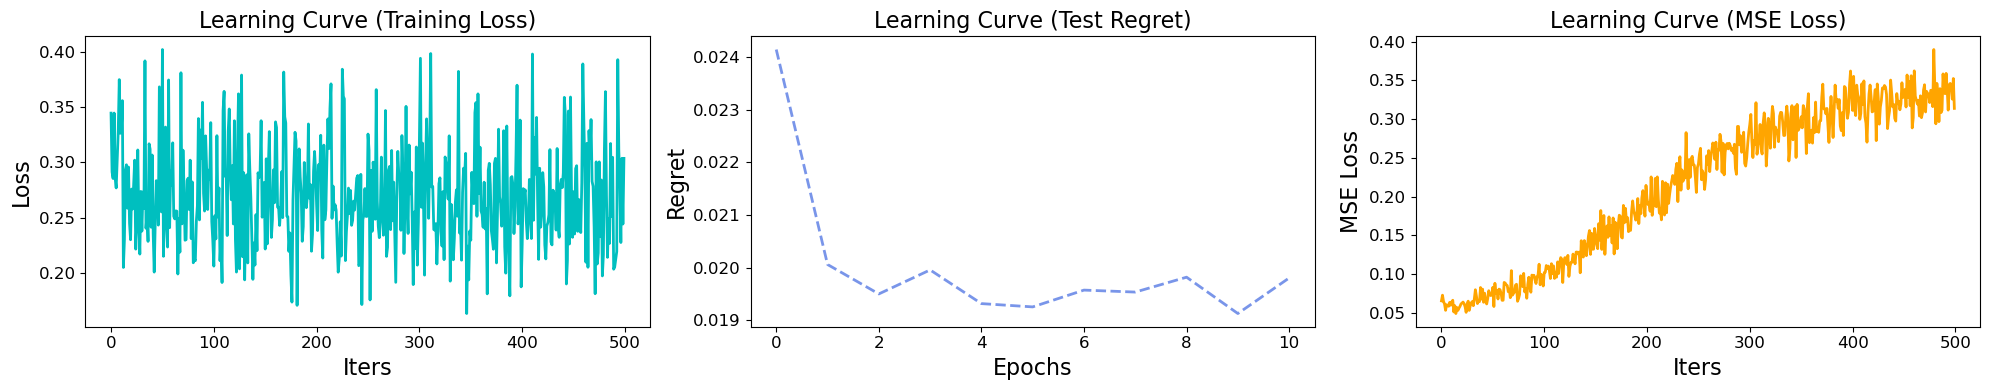

In [70]:
# Set up the model, optimizer, and MSE loss
optmodel = optModelMatrix
model = SimpleNeuralNetwork(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLossMatrix(optmodel,Q)

# Run the training
loss_log, loss_log_regret, mse_loss_log = trainModelMatrix(model, criterion, optmodel, loader_train, loader_test, num_epochs=10, lr=1e-3)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret, mse_loss_log)